In [21]:
# Importações necessárias
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import zipfile
cv2.__version__

'4.10.0'

In [22]:
import tensorflow
tensorflow.__version__

'2.17.1'

In [23]:
# Conexão com o google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
'''path = "/content/gdrive/MyDrive/materiasi/Material.zip" # Armazenamento do caminho dos arquivos
zip_obj = zipfile.ZipFile(file = path, mode = "r") # Acesso do arquivo no modo de leitura
zip_obj.extractall("/content/gdrive/MyDrive/materiasi") # Extração dos arquivos zipados
zip_obj.close # Liberação de memória'''

'path = "/content/gdrive/MyDrive/materiasi/Material.zip" # Armazenamento do caminho dos arquivos\nzip_obj = zipfile.ZipFile(file = path, mode = "r") # Acesso do arquivo no modo de leitura\nzip_obj.extractall("/content/gdrive/MyDrive/materiasi") # Extração dos arquivos zipados\nzip_obj.close # Liberação de memória'

In [25]:
'''base_imgs = '/content/drive/MyDrive/materiasi/Material/fer2013.zip'
zip_obj = zipfile.ZipFile(file = base_imgs, mode = "r")
zip_obj.extractall("/content/gdrive/MyDrive/materiasi")
zip_obj.close'''

'base_imgs = \'/content/drive/MyDrive/materiasi/Material/fer2013.zip\'\nzip_obj = zipfile.ZipFile(file = base_imgs, mode = "r")\nzip_obj.extractall("/content/gdrive/MyDrive/materiasi")\nzip_obj.close'

In [26]:
data = pd.read_csv('/content/drive/MyDrive/materiasi/fer2013/fer2013.csv') # Carregamento da base de dados

In [27]:
pixels  = data['pixels'].tolist() # Converte a coluna de pixels em uma list

In [28]:
largura, altura = 48, 48 # Define a largura e altura das imagens
faces = [] # lista vazia por enquanto
for pixel in pixels:
  face = [int(p) for p in pixel.split(' ')] # Remove os espacos em branco e converte para inteiro
  face = np.asarray(face).reshape(largura, altura) # Converte o tamanho
  faces.append(face) # Adiciona ao vetor

In [29]:
faces = np.asarray(faces) # Converte para um array numpy

In [30]:
faces = np.expand_dims(faces, -1) # Adiciona uma nova dimensao para ficar compativel com o tensorflow

In [31]:
def normalizar(x): # funcao para normalizar os dados
  x = x.astype('float32') # Converte para float
  x = x/255.0 # Deixa os valores entre 0 e 1
  return x

In [32]:
faces = normalizar(faces) # chama a funcao para cada valor de faces

In [33]:
emocoes = pd.get_dummies(data['emotion']).values # Tranforma os valores em true e false

In [34]:
# Importaç~eos necessárias
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model, model_from_json

In [35]:
x_train, x_test, y_train, y_test = train_test_split(faces, emocoes, test_size=0.1, random_state = 42) # Separação dos dados em treino e teste
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state = 41)


In [36]:
np.save('mod_xtest', x_test)
np.save('mod_ytest', y_test)

In [37]:
num_features = 128 # Numero de caracteristica
num_labels = 7 # Numero de classes
batch_size = 32 # indica qual a frequencia de atualização dos pesos
epochs = 5 # Numero de épocas (Reduzi para cinco pois estava demorando muito e o objetivo principal é aprender a como fazer)
width, height = 48, 48 # Altura e largura

# Primeira parte
model = Sequential() # Indica que o modelo vai receber uma sequencia de camadas
model.add(Conv2D(num_features, kernel_size=(2,2), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer = l2(0.01))) # Primeira camada convolucional
model.add(Conv2D(num_features, kernel_size=(2,2), activation='relu', padding='valid')) # Segunda camada convolucional
model.add(BatchNormalization()) # Normalização dos dados
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # Camada de pooling
model.add(Dropout(0.3)) # Camada de dropout
# Segunda parte
model.add(Conv2D(2*num_features, kernel_size=(2,2), activation='relu', padding = 'valid'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(2,2), activation='relu', padding = 'valid'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))
model.add(Flatten()) # Tansforma a matriz em um vetor
model.add(Dense(num_labels, activation='softmax')) # Camada de saida
model.summary() # Mostra toda a estrutura construída

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 47, 47, 128)         │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 46, 46, 128)         │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 46, 46, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 22, 22, 256)         │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 22, 22, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 21, 21, 256)         │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 21, 21, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │         179,207 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 641,799 (2.45 MB)

 Trainable params: 640,519 (2.44 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [38]:
model.compile(loss= 'categorical_crossentropy', optimizer = Adam( learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), metrics=['accuracy']) # Compilação do modelo
arquivo_modelo = 'modelo_01_expressoes.keras' # Nome do arquivo do modelo
arquivo_modelo_json = 'modelo_01_expressoes.json' # Nome do arquivo do modelo json
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=2, verbose=1 ) # Diminui o lr
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto') # Parada antes das épocas definidas caso não haja evolução durante 8 épocas consecutivas
checkpointer = ModelCheckpoint(arquivo_modelo, monitor='val_loss', verbose=1, save_best_only=False) # Salva os melhores valores

In [39]:
model_json = model.to_json() # Salva o modelo em json
with open(arquivo_modelo_json, 'w') as json_file:
  json_file.write(model_json)

In [40]:
history = model.fit(np.array(x_train), np.array(y_train), batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(np.array(x_val), np.array(y_val)), shuffle=True, callbacks=[lr_reducer, checkpointer, early_stopper]) # Treinamento do modelo

Epoch 1/5
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2432 - loss: 5.1570
Epoch 1: saving model to modelo_01_expressoes.keras
909/909 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - accuracy: 0.2433 - loss: 5.1564 - val_accuracy: 0.2053 - val_loss: 3.6436 - learning_rate: 0.0010
Epoch 2/5
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3089 - loss: 3.2788
Epoch 2: saving model to modelo_01_expressoes.keras
909/909 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.3089 - loss: 3.2784 - val_accuracy: 0.3650 - val_loss: 1.9659 - learning_rate: 0.0010
Epoch 3/5
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4012 - loss: 1.8549
Epoch 3: saving model to modelo_01_expressoes.keras
909/909 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.4012 - loss: 1.8548 - val_accuracy: 0.4622 - val_loss: 1.4648 - learning_rate: 0.0010
Epoch 4/5
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4657 - loss: 1.4313
Epoch 4: saving model to modelo_01_expressoes.keras
909/909 ━━━━━━━━━━━

In [41]:
print(history.history)

{'accuracy': [0.260974258184433, 0.3297784626483917, 0.4116554260253906, 0.46907252073287964, 0.4965941905975342], 'loss': [4.599823951721191, 2.8432679176330566, 1.7418631315231323, 1.416987657546997, 1.3291208744049072], 'val_accuracy': [0.205263152718544, 0.3650154769420624, 0.4622291028499603, 0.4938080608844757, 0.4749225974082947], 'val_loss': [3.6436235904693604, 1.9658571481704712, 1.4647727012634277, 1.3542791604995728, 1.429567575454712], 'learning_rate': [0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513]}


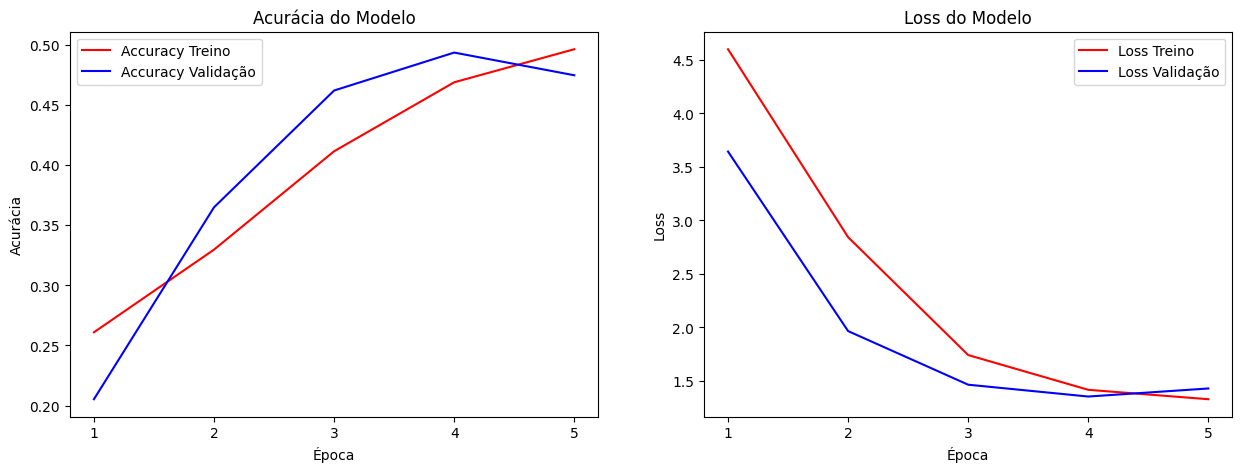

In [42]:
def plota_historico(historico_modelo):  # Função que gera o gráfico
    fig, axis = plt.subplots(1, 2, figsize=(15, 5))  # tamanhos
    epochs = range(1, len(historico_modelo.history['accuracy']) + 1)
    # Gráfico da acurácia
    axis[0].plot(epochs, historico_modelo.history['accuracy'], 'r', label='Accuracy Treino')  # acurácia do treino
    axis[0].plot(epochs, historico_modelo.history['val_accuracy'], 'b', label='Accuracy Validação')  # acurácia da validacão
    axis[0].set_title('Acurácia do Modelo')  # título
    axis[0].set_ylabel('Acurácia')  # rótulo do eixo Y
    axis[0].set_xlabel('Época')  # rótulo do eixo X
    axis[0].set_xticks(np.arange(1, len(epochs) + 1, max(1, len(epochs) // 10)))
    axis[0].legend(loc='best') # legenda
    # Grafico da loss
    axis[1].plot(epochs, historico_modelo.history['loss'], 'r', label='Loss Treino')  # loss do treino
    axis[1].plot(epochs, historico_modelo.history['val_loss'], 'b', label='Loss Validação')  # loss da validacao
    axis[1].set_title('Loss do Modelo')  # título
    axis[1].set_ylabel('Loss')  # rótulo do eixo Y
    axis[1].set_xlabel('Época')  # rótulo do eixo X
    axis[1].set_xticks(np.arange(1, len(epochs) + 1, max(1, len(epochs) // 10)))
    axis[1].legend(loc='best')  # legenda
plota_historico(history) # chama a função passando o historico


In [43]:
scores = model.evaluate(np.array(x_test), np.array(y_test), batch_size = batch_size)

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4833 - loss: 1.4710


In [44]:
scores

[1.4755184650421143, 0.4761772155761719]

In [45]:
print("Loss: " + str(scores[0]))
print("Acurácia: " + str(scores[1]))

Loss: 1.4755184650421143
Acurácia: 0.4761772155761719
